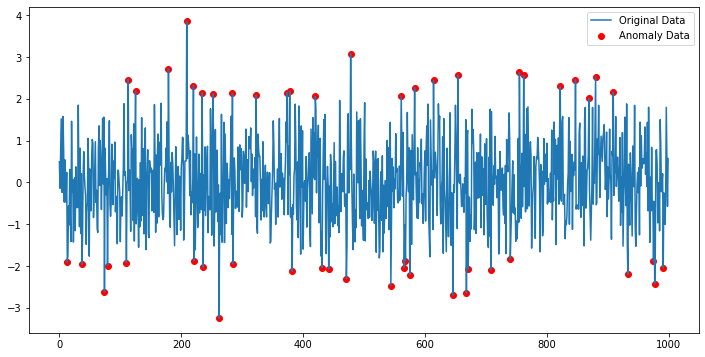

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
# quick example
# Generate some data for demonstration
np.random.seed(42)
data = pd.Series(np.random.normal(loc=0, scale=1, size=1000))

# Fit the isolation forest model to the data
model = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.05), random_state=42) # contamination: means 5% data are the anomaly data
model.fit(data.values.reshape(-1, 1))

# Make predictions on the data
anomaly_mask = model.predict(data.values.reshape(-1, 1)) == -1
anomaly_data = data[anomaly_mask]

# Plot the original data along with the detected anomalies
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data, label='Original Data')
ax.scatter(anomaly_data.index, anomaly_data, color='r', label='Anomaly Data')
ax.legend()
plt.show()

In [2]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from enum import Enum
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

import random
import datetime
import warnings
warnings.filterwarnings('ignore')
     

# Prepare Data functions
# get mean features per second
def get_mean_features_sec(df, mean_features, groupby_features):
  for column_name in mean_features:
    new_column_name = 'mean_second_' + column_name
    df[new_column_name] = df.groupby(groupby_features)[column_name].transform('mean')
  return df

# get mean features per mintue
def get_mean_features_minute(df, mean_features, groupby_features):
  for column_name in mean_features:
    new_column_name = 'mean_minute_' + column_name
    df[new_column_name] = df.groupby(groupby_features)[column_name].transform('mean')
  return df


# add shift features 
def get_shift(n, columns, df, session_column_name):
  features_ = []
  df_data = df
  for i in range(n):
    for c in columns:
      new_feature_name = c + '_shifted_' + str(i+1)
      df_data[new_feature_name] = df_data.groupby(session_column_name)[c].shift(i+1)
      features_ = features_ + [new_feature_name]
  return df_data, features_

df_data = pd.read_csv('./Train_Mouse.csv')
df_data.shape

# sorted buy timestamp
df_data = df_data.sort_values('timestamp').reset_index().drop(labels='index', axis=1)

# labeling user_id and session_id
user_id_array = df_data['user_id'].unique()
user_id_map = {val:idx for idx,val in enumerate(user_id_array)}
df_data['user_id_new'] = df_data['user_id'].map(lambda x: user_id_map[x])
session_id_array = df_data['session_id'].unique()
session_id_map = {val:idx for idx,val in enumerate(session_id_array)}
df_data['session_id_new'] = df_data['session_id'].map(lambda x: session_id_map[x])

# labeling + one-hot for event_type
event_list = ['', 'RELEASE', 'MOVE', 'WHEEL', 'DRAG', 'CLICK']
df_data['e'] = df_data['event_type'].map(lambda x: event_list[x])
one_hot_df = pd.get_dummies(df_data['e'], prefix='event')
df_data = pd.concat([df_data, one_hot_df], axis=1)
categorial_cols = ['event_MOVE', 'event_WHEEL', 'event_DRAG', 'event_CLICK']

# time features
df_data['datetime'] = pd.to_datetime(df_data['timestamp'], unit='ms')
df_data['day'] = df_data['datetime'].dt.date
df_data['hour'] = df_data['datetime'].dt.hour
df_data['minute'] = df_data['datetime'].dt.minute
df_data['second'] = df_data['datetime'].dt.second
time_features = ['hour', 'minute', 'second']

# timestamp features
df_data['time_stamp_min'] = df_data.groupby('session_id_new')['timestamp'].transform('min')
df_data['time_stamp'] = df_data['timestamp'] - df_data['time_stamp_min']
df_data['time_diff'] = df_data.groupby('session_id_new')['timestamp'].diff()

# calculate the x_diff y_diff and distance btw (x,y)
df_data['x_diff'] = df_data.groupby('session_id_new')['screen_x'].diff()
df_data['y_diff'] = df_data.groupby('session_id_new')['screen_y'].diff()
df_data['xy_diff'] = np.sqrt(df_data['x_diff']**2 + df_data['y_diff']**2)

# calculate the speed
df_data['x_speed'] = np.abs(df_data['x_diff'] / df_data['time_diff'])
df_data['y_speed'] = np.abs(df_data['y_diff'] / df_data['time_diff'])
df_data['xy_speed'] = df_data['xy_diff'] / df_data['time_diff']

df_data = df_data.dropna()
df_data.shape

CPU times: user 368 ms, sys: 14.7 ms, total: 383 ms
Wall time: 414 ms


(11513, 29)

# Anomaly Detection

In [3]:
df_data[['screen_x', 'screen_y', 'x_speed', 'y_speed', 'xy_speed']].describe()

,screen_x,screen_y,x_speed,y_speed,xy_speed
count,11513.000000,11513.000000,11513.000000,11513.000000,11513.000000
mean,719.157762,449.863823,2.098435,1.282416,2.597972
std,435.726740,210.009102,3.509298,2.367735,4.149680
min,0.000000,67.975080,0.000000,0.000000,0.000000
25%,395.200000,293.000000,0.062500,0.055556,0.132250
50%,672.000000,443.597660,0.516304,0.367347,0.810243
75%,986.000000,588.000000,3.191918,1.913043,4.016495
max,2239.980500,1186.085900,112.000000,114.000000,159.812390


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Fit the isolation forest model to the data
model = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.05), random_state=42)


In [5]:
anomaly_features = ['screen_x', 'screen_y', 'x_speed', 'y_speed', 'xy_speed']
anomaly_mask_pd = pd.DataFrame()

for column_name in anomaly_features:
  model.fit(df_data[column_name].values.reshape(-1, 1))
  # Make predictions on the data
  anomaly_mask = model.predict(df_data[column_name].values.reshape(-1, 1)) == -1
  index_new_name = 'ab_'+column_name
  anomaly_mask_pd[index_new_name] = anomaly_mask

anomaly_mask_pd['pick_index'] = ~(anomaly_mask_pd.iloc[:, 0:5].any(axis=1))

df_data = df_data[anomaly_mask_pd['pick_index'].values]
df_data = df_data.reset_index().drop(labels='index', axis=1)

In [6]:
df_data[['screen_x', 'screen_y', 'x_speed', 'y_speed', 'xy_speed']].describe()

,screen_x,screen_y,x_speed,y_speed,xy_speed
count,9789.000000,9789.000000,9789.000000,9789.000000,9789.000000
mean,676.690525,432.882147,1.511916,0.908489,1.858599
std,373.952032,181.730597,2.034102,1.176790,2.275790
min,21.600000,93.851290,0.000000,0.000000,0.000000
25%,390.000000,293.000000,0.050938,0.044059,0.110559
50%,651.200000,436.000000,0.400000,0.292576,0.597283
75%,938.000000,570.000000,2.490599,1.484848,3.295630
max,1619.000000,875.000000,8.058824,5.027519,9.313730


# Feature Engineering

In [7]:
mean_features = ['x_speed', 'y_speed', 'xy_speed', 'screen_x', 'screen_y', 'event_type']
df_data = get_mean_features_sec(df_data.dropna(), mean_features, ['session_id_new', 'day', 'hour', 'minute', 'second'])

# we take 30 step
aggragation_cols = [ 'mean_second_x_speed', 'mean_second_y_speed', 'mean_second_xy_speed', 
                     'mean_second_screen_x', 'mean_second_screen_y', 'mean_second_event_type'
                  ]
n_step = 28
df_data, features_add = get_shift(n_step, aggragation_cols, df_data, 'session_id_new')

df_data.columns

Index(['uid', 'session_id', 'user_id', 'timestamp', 'event_type', 'screen_x',
       'screen_y', 'user_id_new', 'session_id_new', 'e',
       ...
       'mean_second_xy_speed_shifted_27', 'mean_second_screen_x_shifted_27',
       'mean_second_screen_y_shifted_27', 'mean_second_event_type_shifted_27',
       'mean_second_x_speed_shifted_28', 'mean_second_y_speed_shifted_28',
       'mean_second_xy_speed_shifted_28', 'mean_second_screen_x_shifted_28',
       'mean_second_screen_y_shifted_28', 'mean_second_event_type_shifted_28'],
      dtype='object', length=203)

# Data Split

In [8]:
# get test dataset: each user one session id
def get_valid_idx(df_data_, n, random_seed = False):
  if random_seed:
    random.seed()
  idx_valid = []
  for i in df_data_.groupby('user_id_new')['session_id_new'].unique():
    idx_valid.append(random.sample(list(i), 2)[0])
    idx_valid.append(random.sample(list(i), 2)[1])
  return np.sort(idx_valid)

In [9]:
idx_valid = get_valid_idx(df_data, 5)
print(f"The session_id picked as test dataset: \n {idx_valid}")

df_valid = df_data[df_data['session_id_new'].isin(idx_valid)]; 
df_train = df_data[~df_data.index.isin(df_valid.index)]; 
df_valid = df_valid.dropna().reset_index().drop(labels='index', axis=1)
df_train = df_train.dropna().reset_index().drop(labels='index', axis=1)

df_train.shape, df_valid.shape

The session_id picked as test dataset: 
 [  0   7   7  11  15  15  16  20  21  25  31  32  34  35  35  38  42  46
  47  49  58  60  61  65  66  70  72  74  79  82  83  90  92  93  97 101
 103 108 112 118]


((4448, 203), (1988, 203))

In [10]:
features_for_train =  features_add + aggragation_cols # numerical_cols + categorial_cols

# get the label as well, check the data shape 
df_train_x = df_train[features_for_train]; df_train_y = df_train['user_id_new'] 
df_valid_x = df_valid[features_for_train];  df_valid_y = df_valid['user_id_new'] 
# when need test dataset: 
# df_test_x = df_test[features_for_train];  df_test_y = df_test['user_id_new'] 

df_train_x.shape, df_valid_x.shape

((4448, 174), (1988, 174))

# XGB

In [11]:
import xgboost as xgb

# prepare the dataset
dtrain = xgb.DMatrix(df_train_x.values, label=df_train_y.values)
dvalid = xgb.DMatrix(df_valid_x.values, label=df_valid_y.values)

# define parameter, 20 classes multi-class classification task
n_classes = 20
params = {
    'objective': 'multi:softprob', # multi-class classification
    'num_class': n_classes, # number of classes : 20
    'eval_metric': 'mlogloss', # evaluation metric
    'max_depth': 6, # maximum depth of a tree
    'eta': 0.1, # learning rate
    'min_child_weight': 3, # minimum sum of instance weight needed in a child
    'subsample': 0.8, # subsample ratio of the training instance
    'colsample_bytree': 0.8, # subsample ratio of columns when constructing each tree
    'verbosity': 1, # print messages while running boosting
    'reg_alpha': 15, 
    'seed': 42 # random seed
}

modelXGB = xgb.train(params, 
                  dtrain, 
                  num_boost_round=2500, 
                  early_stopping_rounds=10, 
                  evals=[(dtrain, 'train'), (dvalid, 'validation')])
     

[0]	train-mlogloss:2.77263	validation-mlogloss:2.90133
Multiple eval metrics have been passed: 'validation-mlogloss' will be used for early stopping.

Will train until validation-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:2.60923	validation-mlogloss:2.83536
[2]	train-mlogloss:2.46711	validation-mlogloss:2.77747
[3]	train-mlogloss:2.34698	validation-mlogloss:2.72826
[4]	train-mlogloss:2.2405	validation-mlogloss:2.68733
[5]	train-mlogloss:2.14646	validation-mlogloss:2.6461
[6]	train-mlogloss:2.06165	validation-mlogloss:2.61512
[7]	train-mlogloss:1.9831	validation-mlogloss:2.58076
[8]	train-mlogloss:1.91104	validation-mlogloss:2.55546
[9]	train-mlogloss:1.84433	validation-mlogloss:2.52926
[10]	train-mlogloss:1.78155	validation-mlogloss:2.50645
[11]	train-mlogloss:1.7254	validation-mlogloss:2.49094
[12]	train-mlogloss:1.66984	validation-mlogloss:2.46692
[13]	train-mlogloss:1.61732	validation-mlogloss:2.44319
[14]	train-mlogloss:1.5697	validation-mlogloss:2.42427
[15]	train-m

# Evaluation

In [12]:
from sklearn.metrics import classification_report

preds_train = modelXGB.predict(dtrain)
y_pred_train = np.argmax(preds_train, axis=1)
print(f"confusion matrix on train dataset: \n {classification_report(df_train_y.values, y_pred_train)}")

preds_valid = modelXGB.predict(dvalid)
y_pred_valid = np.argmax(preds_valid, axis=1)
print(f"confusion matrix on test dataset: \n {classification_report(df_valid_y.values, y_pred_valid)}")

confusion matrix on train dataset: 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       109
           1       1.00      1.00      1.00       170
           2       0.94      1.00      0.97       332
           3       1.00      0.97      0.98       299
           4       1.00      1.00      1.00       235
           5       0.98      0.99      0.99       260
           6       1.00      1.00      1.00       414
           7       0.99      1.00      1.00       318
           8       1.00      1.00      1.00       290
           9       0.99      0.98      0.98       208
          10       1.00      0.98      0.99       133
          11       0.99      0.98      0.99       181
          12       0.99      0.99      0.99       186
          13       0.99      0.99      0.99       175
          14       0.98      1.00      0.99       156
          15       1.00      1.00      1.00       337
          16       1.00      1.00      1.00 